# **Assignment 2: Direct Illumination**

## ECSE 446/546: Realistic/Advanced Image Synthesis, Fall 2021

#### Due: Monday, November 15, 2021 at 11:59pm EDT on [myCourses](https://mycourses2.mcgill.ca/)

#### Weight: 25% (ECSE 446) / 20% (ECSE 546)

*In this assignment, you will implement Monte Carlo estimators for direct illumination.*

The *bonus* questions in the end are for extra credit and are optional. Please attempt these *bonus* questions only after you have managed to solve the remainder of the assignment. There is no partial credit for bonus questions.


---

## **Assignment Submission Process**

Modify the `ipynb` notebook we provide on myCourses and submit your modified file, renamed according to your student ID, as

<font color="red">A2-[YourStudentID].ipynb</font>

For example, if your student ID is **123456789**, then your submission filename should be **A2-123456789.ipynb**.

> Note that every time you submit a new file, your previous submission will be overwritten.
**All submissions must be made using myCourses.**
You can submit as many times as you like, but we will only grade the last submission.

This assignment is to be completed *individually*.

### Late policy

Failure to submit a (valid) assignment on time will result in a score of **zero (0%)** on the assignment.
**We will not grant extensions.**
Exceptional circumstances will be treated as specified in [McGill's Policies on Student Rights and Responsibilities](https://www.mcgill.ca/students/srr/).

<font color="red"><b>Late days:</b> To account for exceptional circumstances, each student is allocated a budget of 4 late days that may be used (without incurring any penalty) over the course of all assignments, beginning assignment 2. To avail late days, please directly reach out to a TA indicating you will hand in your assignment late (and specifying the number of late days you intend to use).</font>

### Plagiarism and cheating
Plagiarism is an academic offense of misrepresenting authorship. This can result in penalties up to expulsion. It is also possible to plagiarise your own work, e.g., by submitting work from another course without proper attribution. When in doubt, attribute!

We expect you to submit your own work. Assignments are individual tasks. That said, we want to promote an environment where you are comfortable discussing ideas together. A good rule to follow: fully understand every solution you submit and only submit code that was written by you.

McGill values academic integrity and students should take the time to fully understand the meaning and consequences of cheating, plagiarism and other academic offenses (as defined in the Code of Student Conduct and Disciplinary Procedures — see these two links [[1]](https://www.mcgill.ca/integrity) [[2]](https://www.mcgill.ca/students/srr/honest)).

In accordance with article 15 of the Charter of Students' Rights, students may submit any written or programming components in either French or English.

### Code comparison

We will use code similarity checkers to detect and deal with cases of plagiarism and cheating.

### Python `import` statements

We provide all import statements required to complete the assignment.
You must not use any `import`s other than the ones we provide.
Doing so will result in a score of **zero (0%)** on the assignment.

## **Pre-requisites** 

**<font color="red"> This assignment requires a few components you implemented in the previous assignment. If you have faced any issues when solving assignment 1, we urge you to reach out to the TAs and ensure your underlying ray tracer implementation is correct, before proceeding to attempt this assignment.  </font>**


### Ray tracing with hard shadows ###

Modify the `shade()` routine you implemented for the ray tracer in assignment 1 to trace shadow rays.

<font color="green">**This might be easier for you to implement in the iPython/Colab notebook provided with assignment 1. Once you have ensured this code works (i.e., shadows appear as expected), paste it into the `shade()` method used in this assignment.**</font>

---

## **Preparation** ##

Let us first install and/or import all necessary modules for this assignment. Note that you are not allowed to import anything apart from the modules in this cell, as they will not be available in our auto-grading environment.

Run the cell below to install and import all necessary modules.

In [3]:
!pip install pyexr

%matplotlib inline

import math
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import pyexr

  Created wheel for pyexr: filename=PyEXR-0.3.10-py2.py3-none-any.whl size=4518 sha256=9ab3b8aacfa16970200be821b5a3f43b3304cf3aae19068da7e4a00b86a93735
  Stored in directory: /root/.cache/pip/wheels/da/c8/fb/f00811aa6cb7b74d76ab5941aea24ecf85fd8ca26f1a53ee39
  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp37-cp37m-linux_x86_64.whl size=189368 sha256=902d95e8216ee1f442542354245ed2cd777578e3d1e6dd4f52b583c49cee1c37
  Stored in directory: /root/.cache/pip/wheels/d1/c6/6c/dcf5d042ed2d547da41021f47957b16bebe9cadfd095765d44
Successfully built pyexr OpenEXR


### Helper Functions

Next, we define some helper functions below that will be useful across the whole assignment.

> **Note**: You are not _required_ to use these helper function implementations. These are only provided to reduce the amount of boilerplate code you need to write.

Specifically,
- `normalize(v)`: Normalizes a vector `v`.
- `distance(a, b)`: Computes the distance between two points `a` and `b`.
- `squaredDistance(a, b)`: Computes the *squared* distance between two points `a` and `b`.
- `lookAt(eye, at, up)`: Computes the viewing transformation matrix.
- `reflect(v)`: Reflect a vector `v` over the normal of a local frame.

*Note that you may also want to define your own helper functions in this cell.*

In [4]:
def normalize(v, eps=1e-8):
    """
    Normalize a vector. Add a tiny eps to the denominator to prevent
    divide-by-zero errors.
    """
    dist = np.linalg.norm(v)
    return v / (dist + eps)


def distance(a, b):
    return np.linalg.norm(b - a)


def squaredDistance(a, b):
    v = b - a
    return np.dot(v.T, v)


def lookAt(eye, at, up):
    """
    Viewing transformation.
    Parameters:
        eye (np.array): eye postion
        at (np.array): the point the eye is looking at (usually, the center of
          an object of interest)
        up (np.array): up vector (vertically upward direction)
    """
    z = normalize(eye - at)
    x = normalize(np.cross(up, z))
    y = normalize(np.cross(z, x))
    A = np.column_stack((x, y, z, eye))
    A = np.row_stack((A, np.array([0, 0, 0, 1])))
    return np.linalg.inv(A)


"""
Reflect a vector in local frame.
"""
def reflect(v):
    return np.array([-v[0], -v[1], v[2]])

"""
Write the image to EXR file
"""
def writeEXR(img, name):
    pyexr.write(name, img)

## **Rendering data structures** ##

We now define essential data structures for our _scene description_. All these data structures **must be used as is, without modification**.

You will notice that some of these data structures are modified to support more complex scene specifications (including materials, lights, etc.).


### Basic structure ###

*   **Scene** class now accepts multiple light sources, and the scene config data takes an extra optional **number of samples** for sampling
*   **Camera** and **Ray** remain the same
*   **Frame** a new class introduced to represent coordinate frame and perform  the world-local transformation
*   **Sampler** is a new class introduced to generate samples

In [5]:
# DO NOT TOUCH
class Scene:
    """ 
    A class used to represent a rendering scene
    Attributes:
        geometry: objects in the scene.
        lights: light info
        camera: camera info
        config: store width, height and fov
    """
    def __init__(self, geometry, lights, camera, config):
        self.geometry = geometry
        self.lights = lights
        self.cam = camera
        # config is a dictionary with keys: width, height, fov, samplingStrategy, numSamples
        self.config = config

# DO NOT TOUCH
class Camera:
    """ 
    A class to represent a camera
    Attributes:
        eye: position of the camera
        at: position where the camera looks at
        up: up direction of the camera
    """
    def __init__(self, eye, at, up):
        self.eye = eye
        self.at = at
        self.up = up

# DO NOT TOUCH
class Ray:
    """ 
    A class to represent a ray
    Attributes:
        o: origin of the ray
        d: direction of the ray
        max: max distance at which the ray is capped (to avoid evaluating 
          indefinitely far points along a ray, we cap it to a large distance)
    """
    def __init__(self, origin, dir, max=1e5):
        self.o = origin
        self.d = dir
        self.max = max

# DO NOT TOUCH
class Frame:
    """ 
    A class to represent a coordinate frame of the given normal
    Attributes:
        normal: normal vector in world space
    """
    def __init__(self, normal):
        self.n = normal
        if abs(normal[0]) > abs(normal[1]):
            invLen = 1 / np.sqrt(normal[0] * normal[0] + normal[2] * normal[2])
            self.t = np.array([normal[2] * invLen, 0, -normal[0] * invLen])
        else:
            invLen = 1 / np.sqrt(normal[1] * normal[1] + normal[2] * normal[2])
            self.t = np.array([0, normal[2] * invLen, -normal[1] * invLen])
        self.s = np.cross(self.t, self.n)
    
    def toLocal(self, v):
        """Convert an input vector v from the world fram to the local frame. """
        return np.array([np.dot(v, self.s), np.dot(v, self.t), np.dot(v, self.n)])
    
    def toWorld(self, v):
        """Convert an input vector v from the local fram to the world frame. """
        return self.s * v[0] + self.t * v[1] + self.n * v[2]

    def cosTheta(self, v):
        return v[2]

# DO NOT TOUCH
class Sampler:
    """ 
    A base class that implements a sampler
    Attributes:
        seed: sampler seed
    """
    def __init__(self, seed):
        random.seed(seed)
    
    def next(self):
        """Draw the next sample (scalar). """
        return random.random()
    
    def next2D(self):
        """Draw the next 2D sample. """
        return np.array([random.random(), random.random()])

### Shape ###

As for the type of shape, originally we only support triangles for mesh-based geometry, now we add a new **Sphere** shape to model spherical shape and spherical light source.
**Triangle** now takes an extra parameter `radiance` for quad lights.


In [8]:
class Triangle:
    """ 
    A class to represent a triangle
    Attributes:
        v0, v1, v2: vertices of the triangle
        mat: material of the triangle
        radiance: (only applicable to quad lights) emission radiance of the triangle
    """
    def __init__(self, v0, v1, v2, mat, radiance=None):
        self.v0 = np.asarray(v0)
        self.v1 = np.asarray(v1)
        self.v2 = np.asarray(v2)
        self.mat = mat

        n = normalize(np.cross(self.v1 - self.v0, self.v2 - self.v0))
        self.frame = Frame(n)

        if radiance is None:
            self.radiance = np.array([0, 0, 0])
        else:
            self.radiance = np.asarray(radiance)

    def intersect(self, r):
      """
      Intersect this triangle with a ray
      Parameters:
          r: ray to intersect
      Returns:
          0 if no hit, otherwise the distance to the hit point
      """
      # TODO: PASTE YOUR A1 IMPLEMENTATION HERE
      
      A = np.transpose(np.array([-r.d, self.v1 - self.v0, self.v2 - self.v0]))
      b = r.o - self.v0
      eps = 1e-5
      # Solve Ax = b
      try:
        x = np.linalg.solve(A, b)
        t = x[0]
        dist = distance(r.o + t * r.d, r.o)
        if 0 <= x[1] <= 1 and 0 <= x[2] <= 1 and 0 <= x[1] + x[2] <= 1 and t > 0 and (dist + eps) < r.max:
            return dist
        else:
            return 0
      except np.linalg.LinAlgError:
          return 0

    def normal(self, hit):
      """
      Computes the normal vector of the triangle at a given point
      Parameters:
          hit: the point where the normal needs to be computed
      Returns:
          the normal vector at the 'hit' point
      """
      return normalize(np.cross(self.v0 - hit, self.v1 - hit))

    def toWorld(self, v):
        return self.frame.toWorld(v)

    def toLocal(self, v):
        return self.frame.toLocal(v)


class Sphere:
    """
    A class to represent a sphere
    Attributes:
        center: center of the sphere
        radius: radius of the sphere
        mat: material of the sphere
        radiance: (only applicable to sphere lights) emission radiance of the sphere
    """
    def __init__(self, center, radius, mat, radiance=None):
        self.center = center
        self.radius = radius
        self.mat = mat
        if radiance is None:
            self.radiance = np.array([0, 0, 0])
        else:
            self.radiance = np.asarray(radiance)    
    
    def intersect(self, r):
        """
        Intersect this sphere with a ray
        Parameters:
            r: ray to intersect
        Returns:
            0 if no hit, otherwise the distance to the hit point
        """
        A = np.dot(r.d, r.d)
        B = 2 * np.dot(r.o - self.center, r.d)
        C = np.dot(r.o - self.center, r.o - self.center) - self.radius * self.radius
        discriminant = B * B - 4 * A * C
        if discriminant < 0:
            return 0
        else:
            t1 = (-B - np.sqrt(discriminant)) / (2 * A)
            if t1 > 0:
                return t1
            t2 = (-B + np.sqrt(discriminant)) / (2 * A)
            if t2 > 0:
                return t2
            else:
                return 0
    
    def normal(self, hit):
        """
        Computes the normal vector of the sphere at a given point
        Parameter:
            hit: the point where the normal needs to be computed
        Returns:
            the normal vector at the 'hit' point
        """
        return normalize(hit - self.center)

### Sampling functions ###

The sampling methods are provided to you, more details on the implementations can be found here:

- *Cosine-weighted Hemispherical Direction Sampling* (from [PBRT3e](https://pbr-book.org/3ed-2018/Monte_Carlo_Integration/2D_Sampling_with_Multidimensional_Transformations)): `cosineSampleHemisphere()` and `cosineHemispherePdf()`
- *Sampling a Cone*: `uniformSampleCone`, `uniformConePdf` (from [PBRT3e](https://pbr-book.org/3ed-2018/Monte_Carlo_Integration/2D_Sampling_with_Multidimensional_Transformations#SamplingaCone))
- *Sampling a Triangle*: `uniformSampleTriangle` (from [PBRT3e](https://pbr-book.org/3ed-2018/Monte_Carlo_Integration/2D_Sampling_with_Multidimensional_Transformations#SamplingaTriangle))
- *Sampling a Phong lobe*: `uniformSamplePhongLobe` and `uniformPhongLobePdf`

Note that each sampling method will return value in **local frame** instead of world frame.


In [9]:
# DO NOT TOUCH
def concentricSampleDisk(sample):
    sampleOffset = 2 * sample - np.ones(2)
    if not any(sample):
        return np.zeros(2)
    if np.abs(sampleOffset[0]) > np.abs(sampleOffset[1]):
        r = sampleOffset[0]
        theta = (math.pi / 4) * (sampleOffset[1] / sampleOffset[0])
    else:
        r = sampleOffset[1]
        theta = math.pi / 2 - (math.pi / 4) * (sampleOffset[0] / sampleOffset[1])
    return r * np.array([np.cos(theta), np.sin(theta)])

# DO NOT TOUCH
def cosineSampleHemisphere(sample):
    d = concentricSampleDisk(sample)
    z = np.sqrt(max(0, 1 - d[0] * d[0] - d[1] * d[1]))
    return np.array([d[0], d[1], z])

# DO NOT TOUCH
def cosineHemispherePdf(v):
    return v[2] / math.pi if v[2] > 0 else 0

# DO NOT TOUCH
def uniformSampleCone(sample, cosThetaMax):
    cosTheta = (1 - sample[0]) + sample[0] * cosThetaMax
    sinTheta = max(0, np.sqrt(1 - cosTheta * cosTheta))
    phi = 2 * math.pi * sample[1]
    return np.array([sinTheta * np.cos(phi), sinTheta * np.sin(phi), cosTheta])

# DO NOT TOUCH
def uniformConePdf(cosThetaMax):
    return 1 / (2 * math.pi * (1 - cosThetaMax))

# DO NOT TOUCH
def uniformSampleTriangle(sample):
    u = np.sqrt(1 - sample[0])
    return np.array([1 - u, u * sample[1]])

# DO NOT TOUCH
def uniformSamplePhongLobe(sample, n):
    z = math.pow(1 - sample[0], 1 / (n + 1))
    r = math.sqrt(1 - z * z)
    phi = 2 * math.pi * sample[1]
    x = r * math.cos(phi)
    y = r * math.sin(phi)
    return np.array([x, y, z])

# DO NOT TOUCH
def uniformPhongLobePdf(v, n):
    return (n + 1) / (2 * math.pi) * math.pow(v[2], n)

### Light sources ###
In this assignment, we will move on to different area lights, and we will mainly work with **Sphere light** and **Quad light**. The code for each light source is provided.

Moreover, we will not only deal with one light source, but with many lights in one scene. We need to sample the light sources stochastically and return their PDF, which is done in ```selectLight()```.


---


For quad lights, we assume the radiance of each triangle is identical.

Another assumption of every scene: there won't be quad lights and sphere lights mixed in a single scene.

There are two blank method `sampleBySolidAngle` and `pdfSolidAngle` in `SphereLight` class, which can be safely ignored now (back to here later).

In [10]:
class QuadLight:
    def __init__(self, v0, v1, v2, v3, radiance):
        self.trig1 = [v0, v1, v2]
        self.trig2 = [v0, v2, v3]
        self.radiance = radiance
        self.area1 = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
        self.area = self.area1 + 0.5 * np.linalg.norm(np.cross(v2 - v0, v3 - v0))
    
    def sampleByArea(self, sampler):
        trig = self.trig1 if self.area1 / self.area >= sampler.next() else self.trig2
        uv = uniformSampleTriangle(sampler.next2D())
        pos = trig[0] * (1 - uv[0] - uv[1]) + trig[1] * uv[0] + trig[2] * uv[1]
        normal = normalize(np.cross(trig[1] - trig[0], trig[2] - trig[0]))
        pdf = 1 / self.area
        return (pos, normal, pdf)

In [1]:
class SphereLight:
    def __init__(self, sphere):
        self.center = sphere.center
        self.radius = sphere.radius
        self.radiance = sphere.radiance
    
    def sampleBySolidAngle(self, sampler, hit):
        """
        Sample a direction towards the cone of directions subtended by this spherical light
        Parameter:
            sampler: a Sampler instance
            hit: the shading point in world frame
        Returns:
            wiWorld: the sampled light direction in world frame
        """
        # TODO: YOUR CODE HERE
        dist = distance(hit, self.center)
        wc = normalize(self.center - hit)
        frame = Frame(-wc)

        # Compute thetaMax
        sinThetaMax = (self.radius ** 2) / (dist ** 2)
        cosThetaMax = (max(0., 1 - sinThetaMax)) ** 0.5
        res = uniformSampleCone(sampler.next2D(), cosThetaMax)
        pos = frame.toLocal(res)
        pos *= self.radius
        pos += self.center
        return normalize((pos - hit))
    
    def pdfSolidAngle(self, sampler, hit):
        """
        Compute the PDF value for sampling a direction towards this spherical light
        Parameter:
            sampler: a Sampler instance
            hit: the shading point in world frame
        Returns:
            pdf: the computed PDF value
        """
        # TODO: YOUR CODE HERE
        sinThetaMax = (self.radius ** 2) / squaredDistance(hit, self.center)
        cosThetaMax = (max(0., 1 - sinThetaMax)) ** 0.5

        return uniformConePdf(cosThetaMax)

In [11]:
def selectLight(scene, sampler):
    idx = int(sampler.next() * len(scene.lights))
    idx = min(idx, len(scene.lights) - 1)
    pdf = 1 / len(scene.lights)
    return (scene.lights[idx], pdf)

### BRDFs ###

We will also further expand our material collection. In assignment 1, we used the `Diffuse` class to model diffuse materials. In this assignment, we will use BRDFs to capture both diffuse and specular material properties. We call this class `DiffuseBRDF`.

Furthermore, we will now begin modeling specular reflection using a Phong BRDF model in the `PhongBRDF` class.

Each BRDF class has three methods:


*   `eval(hit, wi, wr)`: Evaluate the BRDF at a hit point **$x$** along an outgoing direction $\omega_o$ (`wr`) and incoming direction $\omega_i$ (`wi`).
*   `sample(sampler, wr)`: Method to support BRDF importance sampling. For a diffuse BRDF, this samples a direction $\omega_i \sim f_s(\mathbf{x}, \omega_i, \omega_o)$ according to a cosine-weighted hemispherical sampling scheme. For Phong BRDF, this samples a direction $\omega_i \sim f_s(\mathbf{x}, \omega_i, \omega_o)$ uniformly distributed according to the Phong specular lobe.
*   `pdf(wi, wr)`: Returns the pdf corresponding to the sampled direction.

---

In Question 2.3 (BRDF importance sampling), you will need to complete the PhongBRDF class first. You can skip this code cell for now -- we will not use it until Question 2.3.

In the implementation of the `eval()` function for `PhongBRDF` we have a diffuse and a glossy term (i.e., lobes). This will also have to be reflected in your sampling function. The Phong model we are implementing is a type of BRDF known as a mixture model as it combines both diffuse and glossy (e.g., Phong) reflection effects.

To do this, we can leverage a stochastic interpretation of the mixture: you stochastically choose between performing either a diffuse or glossy reflection event at each BRDF sampling decision. Then, depending on your stochastic choice, apply the appropriate importance sampling scheme.

For example, for a mixture model that's 50% diffuse and 50% glossy, instead of evaluating a BRDF that's a weighted sum of these lobes, you'll use a stochastic decision that will treat the reflection as a purely (i.e., 100%) diffuse reflection 50% of the time, and as a purely (i.e., 100%) glossy reflection the other 50% of the time (on average). When you choose to reflect diffusely, you will use **cosine-weighted importance sampling**; otherwise, **cosine-power (Phong lobe) importance sampling** for the glossy case. Remember, you will need to take into account the probability of choosing that type of sampling when you do the reweighting of the contribution within the PDF evaluation.

Instead of always assuming a 50/50 split between diffuse and glossy reflection in the mixture, use the diffuse ($k_d$) and glossy ($k_s$) reflection coefficients as their respective weights. These weights are normalized, i.e., $k_d$ + $k_s$ = 1. 
The weight (probability) for specular sampling is given as `specularSamplingWeight`. The diffuse weight can be calculated as `1.0 - specularSamplingWeight`.

In [13]:
class DiffuseBRDF:
    """ 
    Diffuse material.
    Attributes:
        albedo: diffuse albedo.
    """
    def __init__(self, albedo):
        self.albedo = np.asarray(albedo)
    
    """
    The BRDF function.
    Parameters:
        hit: hitting point.
        wi: incident light direction in surface patch's local frame.
        wr: reflection direction in surface patch's local frame.
    """
    def eval(self, hit, wi, wr):
        frame = Frame(np.array([0, 0, 1]))
        return self.albedo / math.pi * frame.cosTheta(wi)
    
    def sample(self, sampler, wr):
        val = np.zeros(3)
        wi = cosineSampleHemisphere(sampler.next2D())
        pdf = cosineHemispherePdf(wi)
        if pdf > 0:
            val = self.eval(np.zeros(3), wi, wr)
        return (val, pdf, wi)
        
    def pdf(self, wi, wr):
        return cosineHemispherePdf(wi)



class PhongBRDF:
    """
    Phong material.
    Attributes:
        kd: diffuse reflection constant.
        ks: specular reflection constant.
        n: shininess.
    """
    def __init__(self, kd, ks, n):
        self.kd = np.array(kd)
        self.ks = np.array(ks)
        self.n = n
        dAvg = (kd[0] + kd[1] + kd[2]) / 3
        sAvg = (ks[0] + ks[1] + ks[2]) / 3
        self.specularSamplingWeight = sAvg / (dAvg + sAvg)

    """
    The BRDF function.
    Parameters:
        hit: hitting point.
        wi: incident light direction in surface patch's local frame.
        wr: reflection direction in surface patch's local frame.
    """
    def eval(self, hit, wi, wr):
        frame = Frame(np.array([0, 0, 1]))
        return (self.kd / math.pi + self.ks * (self.n + 2) / math.pi * math.pow(max(np.dot(wi, reflect(wr)), 0), self.n)) * frame.cosTheta(wi)

    """
    BRDF importance sampling.
    Parameters:
        sampler: a Sampler instance.
        wr: w_r in surface's local frame.
    """
    def sample(self, sampler, wr):
        val = np.zeros(3)
        prob_spec = self.specularSamplingWeight
        prob_diff = 1. - prob_spec
        prob = sampler.next()

        if  prob < prob_spec:
            wi = uniformSamplePhongLobe(sampler.next2D(), self.n)
            pdf = uniformPhongLobePdf(wi, self.n)
        else:
            wi = cosineSampleHemisphere(sampler.next2D())
            pdf = prob_diff * cosineHemispherePdf(wi)


        val = self.eval(np.zeros(3), wi, wr)
        return (val, pdf, wi)

    # note that v is wi in Phong lobe's local frame
    def pdf(self, wi, wr):
      return uniformPhongLobePdf(wi, self.n)

## **Question 1: Monte Carlo estimator for direct illumination (20 Points)** ##


In this section, you will implement a Monte Carlo estimator for direct illumination with an area light.

For **your first task** you need to paste your A1's implementation of `intersect` and `renderRaytracing` here. Note that `renderRaytracing` has been renamed to just `render` (for convenience; since this assignment only uses ray tracing). The `trace` and `render` methods now also require an extra parameter (`sampler`).

<font color="green">**(NEW) In this assignment, you do not need to clip the output color in `render` in this assignment.**</font>

In [14]:
def intersect(scene, ray):
    # TODO: PASTE YOUR A1 IMPLEMENTATION HERE
    primitives = scene.geometry

    # Initialize return values
    has_hit, hit_id, t = False, -1, ray.max

    # Set up distance range
    t_min, t_max = 0., ray.max

    # loop
    for (index, primitive) in zip(range(len(primitives)), primitives):
        t = primitive.intersect(ray)
        if t_min < t < t_max:
            t_max = t
            hit_id = index
            has_hit = True
    dist = t_max
    return has_hit, hit_id, dist
    pass

In [15]:
def trace(scene, ray, sampler):
    """ 
    Trace a ray in the scene, and shade the hit point
    Parameters:
      scene: scene to render
      ray: ray to trace
      sampler: a Sampler instance
    Returns:
      light radiance at the hit point 
    """
    
    intersection = intersect(scene, ray)
    hasHit = intersection[0]
    if not hasHit:
        return np.zeros(3)
    hitObjectId = intersection[1]  # object id
    t = intersection[2] # distance
    
    if scene.config['samplingStrategy'] == 'cosine-hemisphere':
        return shadeCosineHemisphere(scene, sampler, ray.o + t * ray.d, scene.geometry[hitObjectId])
    elif scene.config['samplingStrategy'] == 'brdf':
        return shadeBRDF(scene, sampler, ray.o + t * ray.d, scene.geometry[hitObjectId])
    elif scene.config['samplingStrategy'] == 'area':
        return shadeArea(scene, sampler, ray.o + t * ray.d, scene.geometry[hitObjectId])
    elif scene.config['samplingStrategy'] == 'solid-angle':
        return shadeSolidAngle(scene, sampler, ray.o + t * ray.d, -ray.d, scene.geometry[hitObjectId])
    elif scene.config['samplingStrategy'] == 'average-pdf':
        return shadeAveragePDF(scene, sampler, ray.o + t * ray.d, -ray.d, scene.geometry[hitObjectId])
    else:
        raise ValueError(f'Unknown sampling strategy: \'{scene.config["samplingStrategy"]}\'.')

In [16]:
def render(scene, sampler):
    """
    Ray tracer main rendering function
    Parameters:
      scene: scene to render
      sampler: a Sampler instance
    Returns:
      rendered image
    """

    # TODO: PASTE YOUR A1 IMPLEMENTATION HERE
    width, height, fovy = scene.config["width"], scene.config["height"], scene.config["fov"] * np.pi / 180
    aspect = width / height
    n = 0.1
    t = n * math.tan(fovy / 2)
    r = t * aspect

    cam = scene.cam
    cam2World = np.linalg.inv(lookAt(cam.eye, cam.at, cam.up))
    x, y, z, eye = cam2World[:-1, 0], cam2World[:-1, 1], cam2World[:-1, 2], cam2World[:-1, 3]

    imgBuffer = np.zeros(shape=(height, width, 3))
    # pixelBuffer = np.zeros(shape=(width, height, 2))

    # set the pivot point at the top left
    for i in range(0, width):
        for j in range(0, height):
            u, v = -r + ((i + 0.5) * 2 * r / width), t - ((j + 0.5) * 2 * t / height)
            # pixel_Cam= np.asarray([u, v, d])
            # dir_Cam = hp.normalize(pixel_Cam)
            dir = normalize(u * x + v * y - n * z)
            ray = Ray(eye, dir)
            imgBuffer[j, i] = trace(scene, ray, sampler)

    # Return your image
    return imgBuffer
    pass



---


Recall the reflection equation, which expresses the reflected radiance at a shade point **x** as an integral over a unit hemisphere centered at **x** of the product of these terms:
$$
L_r(\mathbf{x}, \omega_r) = \int_{\mathcal{H}^2} L_i(\mathbf{x}, \omega_i) f_r(\mathbf{x}, \omega_i, \omega_o) V(\mathbf{x},\mathbf{y}) \cos{\theta_i} \,\mathrm{d}\omega_i.
$$

A correct but naive way of estimating the reflection equation is to sample directions uniformly over the (hemi)sphere. While a good baseline to start with for validation purposes, your first estimator will instead implement
**cosine-weighted hemispherical importance sampling**. Your task would be implementing this Monte Carlo estimator and testing it on the Cornell Box scene.

In [17]:
def shadeCosineHemisphere(scene, sampler, hitPoint, hitObject):
    # If the hit point is an emissive surface (i.e., has an associated radiance),
    # return the radiance
    if np.any(hitObject.radiance):
        return hitObject.radiance
    
    # Initialize variable to store outgoing radiance
    Lr = np.zeros(3)
    for i in range(scene.config['numSamples']):
        # Draw a sample (direction) from the cosineSampleHemisphere() method
        wiLocal = normalize(cosineSampleHemisphere(sampler.next2D()))# TODO: YOUR CODE HERE (one line expected)
        # Evaluate its PDF (use cosineHemispherePdf)
        pdf = cosineHemispherePdf(wiLocal)# TODO: YOUR CODE HERE (one line expected)
        
        # Convert the hit object from local frame to world frame
        wiWorld = hitObject.frame.toWorld(wiLocal)
        # Trace a shadow ray and compute its hit points with the scene
        shadowRay = Ray(hitPoint + wiWorld * 0.001, wiWorld)
        shadowInfo = intersect(scene, shadowRay)
        # Handle shadows
        if shadowInfo[0]:
            Li = scene.geometry[shadowInfo[1]].radiance
            wrWorld = normalize(scene.cam.eye - hitPoint)
            wrLocal = hitObject.frame.toLocal(wrWorld)
            cosTheta = wiLocal[2]
            Lr += Li * hitObject.mat.eval(hitPoint, wiLocal, wrLocal) / pdf
    
    return Lr / scene.config['numSamples']


---

To test your new estimator, we will load the Cornell Box scene and render it. 


Note that `samplingStrategy` and `numSamples` have become new arguments for this method.

This estimator can be extremely inefficient: light sources may only subtend a small solid angle so that many rays could be wasted, causing the algorithm to produce noisy images at a low number of sampling.

Initialize a sampler using your **student ID**.
This sampler will be used across the whole assignment.

In [18]:
sampler = Sampler(260913584)

Load the cbox scene.

In [19]:
def loadCornellBox(width, height, samplingStrategy, numSamples):
    objects = [
    # Light
    Triangle([343.0, 548.7999, 227.0], [343.0, 548.7999, 332.0], [213.0, 548.7999, 332.0], None, [60, 60, 60]),
    Triangle([343.0, 548.7999, 227.0], [213.0, 548.7999, 332.0], [213.0, 548.7999, 227.0], None, [60, 60, 60]),
    # Floor
    Triangle([552.8, 0, 0], [0, 0, 0], [0, 0, 559.2], DiffuseBRDF([1, 1, 1])),
    Triangle([552.8, 0, 0], [0, 0, 559.2], [552.8, 0, 559.2], DiffuseBRDF([1, 1, 1])),
    # Ceiling
    Triangle([556.0, 548.8, 0.0], [556.0, 548.8, 559.2],[0.0, 548.8, 559.2], DiffuseBRDF([1, 1, 1])),
    Triangle([556.0, 548.8, 0.0], [0.0, 548.8, 559.2], [0.0, 548.8, 0.0], DiffuseBRDF([1, 1, 1])),
    # Back Wall
    Triangle([549.6, 0.0, 559.2], [0.0, 0.0, 559.2], [0.0, 548.8, 559.2], DiffuseBRDF([1, 1, 1])),
    Triangle([549.6, 0.0, 559.2], [0.0, 548.8, 559.2], [556.0, 548.8, 559.2], DiffuseBRDF([1, 1, 1])),
    # Right Wall
    Triangle([0.0, 0.0, 559.2 ], [0.0, 0.0, 0.0], [0.0, 548.8,   0.0], DiffuseBRDF([0, 1, 0])),
    Triangle([0.0, 0.0, 559.2], [0.0, 548.8, 0.0], [0.0, 548.8, 559.2], DiffuseBRDF([0, 1, 0])),
    # Left Wall
    Triangle([552.8, 0.0, 0.0], [549.6, 0.0, 559.2], [556.0, 548.8, 559.2], DiffuseBRDF([1, 0, 0])),
    Triangle([552.8, 0.0, 0.0], [556.0, 548.8, 559.2], [556.0, 548.8, 0.0], DiffuseBRDF([1, 0, 0])),
    # Short Block
    Triangle([130.0, 165.0,  65.0], [82.0, 165.0, 225.0], [240.0, 165.0, 272.0],  DiffuseBRDF([1, 1, 1])),
    Triangle([130.0, 165.0,  65.0], [240.0 ,165.0, 272.0], [290.0, 165.0, 114.0], DiffuseBRDF([1, 1, 1])),
    Triangle([290.0, 0.0, 114.0], [290.0, 165.0, 114.0], [240.0, 165.0, 272.0], DiffuseBRDF([1, 1, 1])),
    Triangle([290.0, 0.0, 114.0], [240.0, 165.0, 272.0], [240.0, 0.0, 272.0], DiffuseBRDF([1, 1, 1])),
    Triangle([130.0, 0.0, 65.0], [130.0, 165.0, 65.0], [290.0, 165.0, 114.0], DiffuseBRDF([1, 1, 1])),
    Triangle([130.0, 0.0, 65.0], [290.0, 165.0, 114.0], [290.0, 0.0, 114.0], DiffuseBRDF([1, 1, 1])),
    Triangle([82.0, 0.0, 225.0], [82.0, 165.0, 225.0], [130.0, 165.0, 65.0], DiffuseBRDF([1, 1, 1])),
    Triangle([82.0, 0.0, 225.0], [130.0, 165.0, 65.0], [130.0, 0.0, 65.0], DiffuseBRDF([1, 1, 1])),
    Triangle([240.0, 0.0, 272.0], [240.0, 165.0, 272.0], [82.0, 165.0, 225.0], DiffuseBRDF([1, 1, 1])),
    Triangle([240.0, 0.0, 272.0], [82.0, 165.0, 225.0], [82.0, 0.0, 225.0], DiffuseBRDF([1, 1, 1])),
    # Tall Block
    Triangle([423.0, 330.0, 247.0], [265.0, 330.0, 296.0], [314.0, 330.0, 456.0], DiffuseBRDF([1, 1, 1])),
    Triangle([423.0, 330.0, 247.0], [314.0, 330.0, 456.0], [472.0, 330.0, 406.0], DiffuseBRDF([1, 1, 1])),
    Triangle([423.0, 0.0, 247.0], [423.0, 330.0, 247.0], [472.0, 330.0, 406.0], DiffuseBRDF([1, 1, 1])),
    Triangle([423.0, 0.0, 247.0], [472.0, 330.0,  406.0], [472.0, 0.0, 406.0], DiffuseBRDF([1, 1, 1])),
    Triangle([472.0, 0.0, 406.0], [472.0, 330.0,406.0], [314.0, 330.0, 456.0], DiffuseBRDF([1, 1, 1])),
    Triangle([472.0, 0.0, 406.0], [314.0, 330.0, 456.0], [314.0, 0.0, 456.0], DiffuseBRDF([1, 1, 1])),
    Triangle([314.0, 0.0, 456.0], [314.0, 330.0, 456.0], [265.0, 330.0, 296.0], DiffuseBRDF([1, 1, 1])),
    Triangle([314.0, 0.0, 456.0], [265.0,  330.0, 296.0], [265.0, 0.0, 296.0], DiffuseBRDF([1, 1, 1])),
    Triangle([265.0, 0.0, 296.0], [265.0, 330.0, 296.0], [423.0, 330.0, 247.0], DiffuseBRDF([1, 1, 1])),
    Triangle([265.0, 0.0, 296.0], [423.0, 330.0, 247.0], [423.0, 0.0, 247.0], DiffuseBRDF([1, 1, 1]))
    ]    
    lights = [QuadLight(objects[0].v0, objects[0].v1, objects[0].v2, objects[1].v2, objects[0].radiance)]
    camera = Camera(np.array([278, 273, -800]), np.array([278, 273, 0]), np.array([0, 1, 0]))
    config = { 'width': width, 'height': height, 'fov': 38, 'samplingStrategy': samplingStrategy, 'numSamples': numSamples }
    return Scene(objects, lights, camera, config)

Debug with low resolution and a small number of samples. For final images, change `imgWidth`, `imgHeight` and `numSamples` here.

In [20]:
imgWidth = 64
imgHeight = 64
numSamples = 64

In [21]:
scene = loadCornellBox(imgWidth, imgHeight, 'cosine-hemisphere', numSamples)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}, \
    sampling strategy: {scene.config['samplingStrategy']}, \
    the number of samples: {scene.config['numSamples']}")
startTime = time.monotonic()
img = render(scene, sampler)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)
writeEXR(img, "output.exr")

Start rendering in resolution: 64x64, fov: 38,     sampling strategy: cosine-hemisphere,     the number of samples: 64


KeyboardInterrupt: ignored

## **Question 2: Importance sampling for direct illumination** ##


In the previous question, you may have noticed how slow the rendering process is, particulary when large numbers of samples are employed. Furthermore, the quality of the rendered image is poor when lower numbers of samples are used.

In class, we looked at importance sampling as a variance reduction scheme when designing a Monte Carlo estimator. The key question, as posed in the lecture slides, is "what terms (in the reflection equation) should we importance sample?". In this question, we will explore various importance sampling schemes and analyze conditions in which they do (not) work well.

### **Question 2.1: Light Surface Importance Sampling (25 points)**



In the previous section, we discussed that many rays may be wasted because the subtended solid angle of the light source is very small. A better strategy is to thus directly sample the surface area of the light, as opposed to sampling subtended solid angle (see illustrations in lecture slides). This strategy results in valid light paths.

In class, we derived the _area_ form of the reflection equation (by modifying the integrand in the _hemispherical_ form using the Jacobian of transforming a differential solid angle $d\mathbf{\omega}$ into a differential area patch $d\mathbf{y}$. When sampling area lights, we therefore use the area form:

$$
L_r(\mathbf{x}, \omega_r) = \int_{A_e} L_e(\mathbf{y}, \mathbf{y} \to \mathbf{x}) f_r(\mathbf{x}, \mathbf{x} \to \mathbf{y}, \omega_r) G(\mathbf{x} \leftrightarrow \mathbf{y}) \,\mathrm{d}\mathbf{y},
$$

where $G$ is a _geometry_ term (includes visibility), $L_e$ is the emission term, and $f_r$ is the BRDF. Note how the domain of integration is now $A_e$ as opposed to the hemisphere $\mathcal{H}^2$. Please see the lecture slides for more information.

---


**Task**: Implement a **light importance estimator** that estimates the integral above by importance sampling the emissive surfaces. As a reference, a uniform sampling strategy (uniformly samples the surface area of the light) is already provided for you in the `QuadLight` class. You could build off of it.
Please implement the light importance estimator in the `shadeArea()` method below.

In [22]:
def shadeArea(scene, sampler, hitPoint, hitObject):
    # YOUR CODE HERE
    if np.any(hitObject.radiance):
        return hitObject.radiance

    # Initialize variable to store outgoing radiance
    Lr = np.zeros(3)
    for i in range(scene.config['numSamples']):
        (pos, normal, pdf) = scene.lights[0].sampleByArea(sampler)

        # Distance
        r = squaredDistance(pos, hitPoint)
        wiWorld = normalize(pos - hitPoint)
        wiLocal = hitObject.frame.toLocal(wiWorld)

        shadowRay = Ray(hitPoint + wiWorld * 0.001, wiWorld)
        shadowInfo = intersect(scene, shadowRay)
        # Handle shadows
        if shadowInfo[0]:
            cosTheta0 = np.dot(normal, -wiWorld)
            Li = scene.geometry[shadowInfo[1]].radiance
            wrWorld = normalize(scene.cam.eye - hitPoint)
            wrLocal = hitObject.frame.toLocal(wrWorld)
            G = (abs(cosTheta0)) / r
            Lr += Li * hitObject.mat.eval(hitPoint, wiLocal, wrLocal) * G/pdf

    return np.clip((Lr / scene.config['numSamples']), 0, 255)

In [23]:
imgWidth = 128
imgHeight = 128
numSamples = 2

Start rendering in resolution: 128x128, fov: 38,     sampling strategy: area,     the number of samples: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished rendering, time taken: 92.00684782200005 seconds


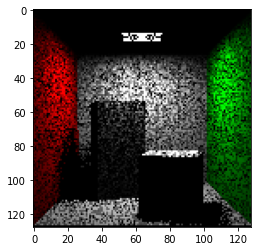

In [ ]:
scene = loadCornellBox(imgWidth, imgHeight, 'area', numSamples)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}, \
    sampling strategy: {scene.config['samplingStrategy']}, \
    the number of samples: {scene.config['numSamples']}")
startTime = time.monotonic()
img = render(scene, sampler)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)
writeEXR(img, "light.exr")

### **Question 2.2 Subtended Solid Angle Sampling (25 points)**





An alternative strategy to directly sampling emissive surfaces (light importance sampling) is to sample according to the subtended solid angle. We will implement subtended solid angle sampling in this sub-question.

Begin by implementing the `sampleBySolidAngle()` method in the `SphereLight` class (please see the function docstring for a description of input arguments and expected return array dimensions). This class returns a direction that is sampled (uniformly) within the solid angle subtended by the light at the shade point.

Then, proceed to implement the `pdfSolidAngle()` method that evaluates the PDF of the sampled direction. Again, see the function docstring for the input arguments and expected return dimensions.

With these done, you can now proceed to fill in the `shadeSolidAngle()` method below with code for your **solid angle estimator**.

In [2]:
def shadeSolidAngle(scene, sampler, hitPoint, wrWorld, hitObject):
    if np.any(hitObject.radiance):
      return hitObject.radiance
    # Initialize variable to store outgoing radiance
    Lr = np.zeros(3)
    for i in range(scene.config['numSamples']):
      (light, pdf_select) = selectLight(scene, sampler)
      wiWorld = light.sampleBySolidAngle(sampler, hitPoint)
      pdf = light.pdfSolidAngle(sampler, hitPoint)
      pdf = pdf * pdf_select
      wiLocal = hitObject.frame.toLocal(wiWorld)
      shadowRay = Ray(hitPoint + wiWorld * 0.001, wiWorld)
      shadowInfo = intersect(scene, shadowRay)
      # Handle shadows
      if shadowInfo[0]:
        Li = scene.geometry[shadowInfo[1]].radiance
        wrWorld = normalize(wrWorld)
        wrLocal = hitObject.frame.toLocal(wrWorld)
        Lr += Li * hitObject.mat.eval(hitPoint, wiLocal, wrLocal) / pdf
    return np.clip((Lr / scene.config['numSamples']), 0, 255)

In class, we looked at examples from the 1995 article "[Optimally combining sampling techniques for Monte Carlo rendering](https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Veach95.pdf)". This article discusses the impact of mixing various importance sampling strategies.

The goal of this sub-question will be to replicate some of the finding in the paper. We will refer to the scene used in the paper (Fig. 2) as the _Veach_ scene (after the lastname of the first author on the paper).

Let us first set the scene up. The scene comprises **5 light sources**, four sphere lights with different sizes (but the same radiant power), and an ambient light source outside the scene.

**Note**: You will need to modify your code to sample from all light sources (as opposed to just one source). This might mean shooting shadow rays to _all_ light sources in the scene. This might also mean sampling all light sources when performing area / subtended solid angle sampling.

In [24]:
def loadVeachScene(width, height, samplingStrategy, numSamples):
    objects = [
        # Light sources
        Sphere([-3.75, 0, 0], 0.016666, None, [900, 200, 200]),
        Sphere([-1.25, 0, 0], 0.05, None, [0, 100, 50]),
        Sphere([1.25, 0, 0], 0.15, None, [0, 5, 10]),
        Sphere([3.75, 0, 0], 0.5, None, [1, 1, 1]),
        Sphere([10, 10, 4], 0.5, None, [800, 800, 800]),    # a bright light to provide the "ambient" light
        # Smooth plate
        Triangle([4.000000, -2.706510, 0.256090], [4.000000, -2.083750, -0.526323], [-4.000000, -2.083750, -0.526323], PhongBRDF([0, 0, 0], [1, 1, 1], 10000)),
        Triangle([-4.000000, -2.083750, -0.526323], [-4.000000, -2.706510, 0.256090], [4.000000, -2.706510, 0.256090], PhongBRDF([0, 0, 0], [1, 1, 1], 10000)),
        # Glossy plate
        Triangle([4.000000, -3.288250, 1.369720], [4.000000, -2.838560, 0.476536], [-4.000000, -2.838560, 0.476536], PhongBRDF([0, 0, 0], [1, 1, 1], 1000)),
        Triangle([-4.000000, -2.838560, 0.476536], [-4.000000, -3.288250, 1.369720], [4.000000, -3.288250, 1.369720], PhongBRDF([0, 0, 0], [1, 1, 1], 1000)),
        # Rough plate
        Triangle([4.000000, -3.730960, 2.700457], [4.000000, -3.433780, 1.745637], [-4.000000, -3.433780, 1.745637], PhongBRDF([0, 0, 0], [1, 1, 1], 100)),
        Triangle([-4.000000, -3.433780, 1.745637], [-4.000000, -3.730960, 2.700457], [4.000000, -3.730960, 2.700457], PhongBRDF([0, 0, 0], [1, 1, 1], 100)),
        # Super rough plate
        Triangle([4.000000, -3.996153, 4.066700], [4.000000, -3.820690, 3.082207], [-4.000000, -3.820690, 3.082207], PhongBRDF([0, 0, 0], [1, 1, 1], 50)),
        Triangle([-4.000000, -3.820690, 3.082207], [-4.000000, -3.996153, 4.066700], [4.000000, -3.996153, 4.066700], PhongBRDF([0, 0, 0], [1, 1, 1], 50)),
        # Floor
        Triangle([-10.000000, -4.146147, -10.000003], [-10.000000, -4.146154, 9.999997], [10.000000, -4.146154, 9.999997], DiffuseBRDF([0.5, 0.5, 0.5])),
        Triangle([10.000000, -4.146154, 9.999997], [10.000000, -4.146147, -10.000003], [-10.000000, -4.146147, -10.000003], DiffuseBRDF([0.5, 0.5, 0.5])),
        # Wall
        Triangle([-10.000000, -10.000000, -2.000006], [10.000000, -10.000000, -2.000006], [10.000000, 10.000000, -1.999994], DiffuseBRDF([0.5, 0.5, 0.5])),
        Triangle([10.000000, 10.000000, -1.999994], [-10.000000, 10.000000, -1.999994], [-10.000000, -10.000000, -2.000006], DiffuseBRDF([0.5, 0.5, 0.5]))
    ]
    lights = [SphereLight(objects[0]), SphereLight(objects[1]), SphereLight(objects[2]), SphereLight(objects[3]), SphereLight(objects[4])]
    camera = Camera(np.array([0.0, 2.0, 15.0]), np.array([0.0, -2.0, 2.5]), np.array([0, 1, 0]))
    config = { 'width': width, 'height': height, 'fov': 35, 'samplingStrategy': samplingStrategy, 'numSamples': numSamples }
    return Scene(objects, lights, camera, config)

In [25]:
imgWidth = 192
imgHeight = 128
numSamples = 4

Start rendering in resolution: 192x128, fov: 35,     sampling strategy: solid-angle,     the number of samples: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished rendering, time taken: 118.80236380100007 seconds


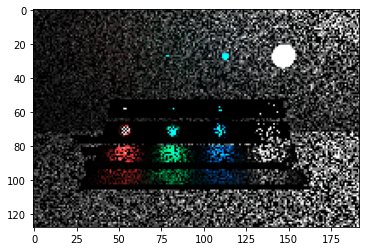

In [ ]:
scene = loadVeachScene(imgWidth, imgHeight, 'solid-angle', numSamples)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}, \
    sampling strategy: {scene.config['samplingStrategy']}, \
    the number of samples: {scene.config['numSamples']}")
startTime = time.monotonic()
img = render(scene, sampler)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)
writeEXR(img, "solidAngle.exr")

### **Question 2.3 BRDF Importance Sampling (30 points)**



BRDF importance sampling is a strategy that samples points with a PDF that is proportional to the BRDF model. So far we have seen two BRDF models, **diffuse** and **Phong**.

Note that BRDF importance sampling for a diffuse BRDF essentially degenerates to cosine-weighted hemispherical sampling, since we are essentially sampling directions according to a cosine-weighted hemispherical distribution. This is already implemented in the previous sections.

In this sub-question, we will exclusively focus on the Phong BRDF and sample uniformly according to its reflected lobe.

Start by implementing the `sample()` and `pdf()` methods in the `PhongBRDF` class. Please read the instructions just above the cells implementing this class for in-depth instructions on how to write your importance sampler. The `pdf()` method simply returns the pdf value, and the `sample()` method returns a tuple comprising **(evaluated Phong, pdf, sampled direction $\omega_i$)**

Once you finish implementing the above two methods, you may implement the `shadeBRDF()` method below.

In [29]:
def shadeBRDF(scene, sampler, hitPoint, hitObject):
    if np.any(hitObject.radiance):
      return hitObject.radiance
    # Initialize variable to store outgoing radiance
    Lr = np.zeros(3)
    for i in range(scene.config['numSamples']):
      (light, pdf_select) = selectLight(scene, sampler)
      mat = hitObject.mat
      wrWorld = normalize(scene.cam.eye - hitPoint)
      wrLocal = hitObject.frame.toLocal(wrWorld)
      (eval, pdf, wiLocal) = mat.sample(sampler, wrLocal)
      pdf *= pdf_select
      wiLocal = normalize(wiLocal)
      wiWorld = hitObject.frame.toWorld(wiLocal)
      shadowRay = Ray(hitPoint + wiWorld * 0.001, wiWorld)
      shadowInfo = intersect(scene, shadowRay)
      # Handle shadows
      if shadowInfo[0]:
        Li = scene.geometry[shadowInfo[1]].radiance
        Lr += Li * eval / pdf
    return np.clip((Lr / scene.config['numSamples']), 0, 255)

In [30]:
imgWidth = 192
imgHeight = 128
numSamples = 32

Start rendering in resolution: 192x128, fov: 35,     sampling strategy: brdf,     the number of samples: 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished rendering, time taken: 754.6034321109996 seconds


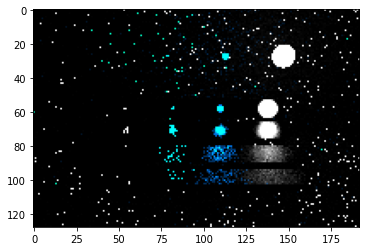

In [ ]:
scene = loadVeachScene(imgWidth, imgHeight, 'brdf', numSamples)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}, \
    sampling strategy: {scene.config['samplingStrategy']}, \
    the number of samples: {scene.config['numSamples']}")
startTime = time.monotonic()
img = render(scene, sampler)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)
writeEXR(img, "brdf.exr")

## **Bonus Questions** ##

The following questions are for extra credit and are not mandatory.

Only attempt this part if you have finished all the required questions. These questions build atop Questions 1 through 4.

You may choose to attempt one or more bonus questions and in no particular order.

The bonus questions are not auto-graded -- you are free to use as many cells and define functions as needed. You may not, however, import libraries other than those approved for this assignment. If in doubt, please talk to the TAs or the instructor.

### Bonus Question 1 - Anti-aliasing (15 points) ###

One of the most common rendering artifacts is the "jaggies". To eliminate these jaggies, anti-aliasing is often used to smooth out the edges. There are a few post-processing techniques for AA but one common and easy method to do it in a ray-tracer would be tracing more rays per pixel.

Implement a basic AA for your ray tracer, note that it will add more computation cost so it might be very slow.

### Bonus Question 2 - MIS (30 points) ###

You will further combine emitter and BRDF sampling using Multiple Importance Sampling (MIS), as introduced by Veach & Guibas (1995).

Recall that two sampling distributions pf and pg can be applied to estimate an integral $I = \int_Ω h(x)$, we
can write an expression for a single Monte Carlo estimator that uses both distributions simultaneously using the MIS formulation, as

$$
I \approx \frac{1}{n_f}\sum_{i=1}^{n_f}\frac{h(X_i)w_f(X_i)}{p_f(X_i)} + \frac{1}{n_g}\sum_{j=1}^{n_g}\frac{h(X_j)w_g(X_j)}{p_g(X_j)} 
$$

where $n_f$ is the number of samples drawn proportional to $p_f$, $n_g$ the number of samples drawn proportional to $p_g$ , and $w_f$ & $w_g$ are special normalization weighting functions chosen so as to not bias the estimator.

Many such weighting functions exist, and one provably good choice uses a balance heuristic, given by the following equation, where $s \in \{f, g\} = S$:

$$
w_s(x)=\frac{n_s p_s(x)}{\sum_{i \in S}n_i p_i(x)}
$$

To compute the weight of a sample point $x$, you need to evaluate the probability $p(x)$ of generating the same sample $x$ for all the importance strategies.

To complete this question, you will need to write a new estimator that does the following:


*   One Monte Carlo loop that samples according to solid angle, additionally you need to weigh the result by the heuristic properly.
*   Another Monte Carlo loop that does a similar procedure, which will sample from Phong BRDF and weigh it appropriately.

Test your code against the Veach scene with the same parameters, here are some reference images, the final render for this part is the same scene, except the lights have different colors.

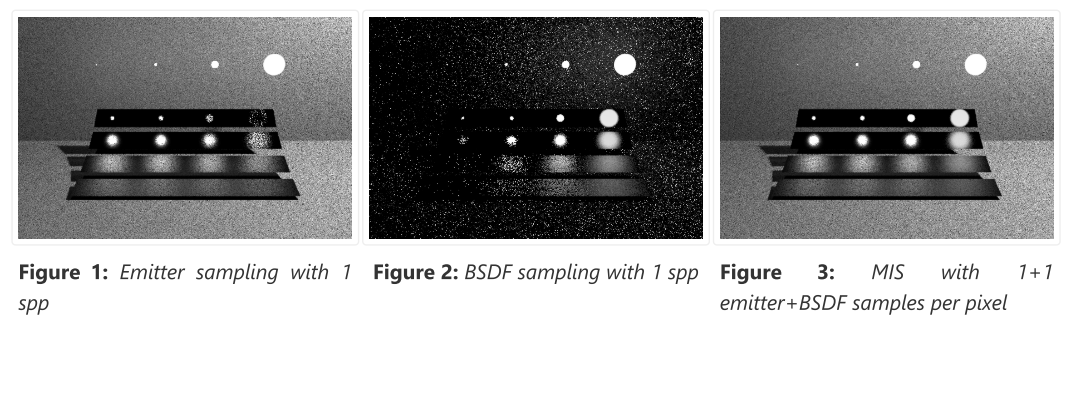


